In [1]:
import random
import time
import os
import math
import numpy as np
import re
import sys
import pandas as pd
import datetime
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
from keras import models, layers, losses, metrics, optimizers
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [2]:
import seaborn as sns
sns.set_style("dark")

#  1.) How many dimensions must the inputs of an RNN layer have? What does each dimension represent? What about its outputs?

- The number of dimensinos for the input of an RNN layer should be the size of the sequence. For example if you have a sequence that you have embedded with 10,000 elements the number of dimensions must be 10,000
- Each dimension represents the embedding of the input data this would be an emedded version of the input data or a sequence that you have embedded into some form
- The output of the RNN memory is the addition of the previous layer memory with the current input memory and the current input with the previous layer if the current neuron in the layer is not forgotten
    - In general the output of an RNN layer is the "short term" (h) and "long term" memory (c)


# 2.)  Consider a CNN composed of three convolutional layers, each with 3 × 3 kernels, a stride of 2, and "same" padding. The lowest layer outputs 100 feature maps, the middle one outputs 200, and the top one outputs 400. The input images are RGB images of 200 × 300 pixels. What is the total number of parameters in the CNN? If we are using 32-bit floats, at least how much RAM will this network require when making a prediction for a single instance? What about when training on a mini-batch of 50 images?

In [3]:
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(layers.Conv2D(400, (3, 3), strides=2, padding="SAME", input_shape=(200, 300, 1)))
model.add(layers.Conv2D(200, (3, 3), strides=2, padding="SAME"))
model.add(layers.Conv2D(100, (3, 3), strides=2, padding="SAME"))

In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 150, 400)     4000      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 75, 200)       720200    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 38, 100)       180100    
Total params: 904,300
Trainable params: 904,300
Non-trainable params: 0
_________________________________________________________________


- Total number of parameters in the CNN is: **904,300**
- For 1 32-bit (4 bytes) float image the memory needed is: **(1 x 4) x (904,300 x 4) = 14,468,800 Bytes** or ***14.47 MB***
- For 50 32-bit float images the memory needed is: **(50 x 4) x (904,300 x 4) = 723,440,000 Bytes** or ***723.44 MB***

# 3.) Use transfer learning for large image classification, going through these steps:
- ## a. Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city, etc.), or alternatively you can use an existing dataset (e.g., https://www.kaggle.com/puneet6060/intel-image-classification).
- ## b. Split it into a training set, a validation set, and a test set.
- ## c. Build the input pipeline, including the appropriate preprocessing operations, and optionally add data augmentation.
- ## d. Fine-tune a pretrained model on this dataset.

## I chose to use the intel data that you linked for us. It was the fastest route. I tried using a pokemon dataset and an anime dataset but many of the classes were not ordered and would have required manual work. Many datasets had only one or two classes with at least 100 images per class which would have been fine but just the same as your cats example. The other datasets looked kinda boring.

In [3]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
trainDir = '\\intel-image-classification\\seg_train\\'

trainBuildingsDir = '\\intel-image-classification\\seg_train\\buildings\\'
trainForestDir = '\\intel-image-classification\\seg_train\\forest\\'
trainGlacierDir = '\\intel-image-classification\\seg_train\\glacier\\'
trainMountianDir = '\\intel-image-classification\\seg_train\\mountian\\'
trainSeaDir = '\\intel-image-classification\\seg_train\\sea\\'
trainStreetDir = '\\intel-image-classification\\seg_train\\street\\'


valDir = '\\intel-image-classification\\seg_test\\'

valForestDir = '\\intel-image-classification\\seg_test\\forest\\'
valGlacierDir = '\\intel-image-classification\\seg_test\\glacier\\'
valMountianDir = '\\intel-image-classification\\seg_test\\mountian\\'
valSeaDir = '\\intel-image-classification\\seg_test\\sea\\'
valStreetDir = '\\intel-image-classification\\seg_test\\street\\'


# testDir = '\\intel-image-classification\\seg_pred\\'
testDir = '\\intel-image-classification\\test\\'


print('total classes:', len(os.listdir(os.getcwd() + trainDir)))

total classes: 6


In [5]:
train_generator = train_datagen.flow_from_directory(os.getcwd() + trainDir,
    target_size=(150, 150),
    batch_size=20,
    class_mode="categorical")

Found 14034 images belonging to 6 classes.


In [6]:
validation_generator = test_datagen.flow_from_directory(os.getcwd() + valDir,
    target_size=(150, 150),
    batch_size=20,
    class_mode="categorical")    

Found 3000 images belonging to 6 classes.


In [13]:
test_generator = test_datagen.flow_from_directory(os.getcwd() + testDir,
    target_size=(150, 150),
    batch_size=20,
    class_mode="categorical")   

Found 72 images belonging to 6 classes.


In [7]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20, 6)


#### Model plotting metrics

In [8]:
def plotloss(history_dict):
    acc = history_dict['acc']
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 10))
    plt.plot(epochs, loss_values, 'r', label='Training loss')
    plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [9]:
def plotacc(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 10))
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Base Model

In [10]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 73984)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

In [11]:
model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['acc'])

In [12]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=50)

Epoch 1/30
100/100 [==============================] - 14s 142ms/step - loss: 1.5747 - acc: 0.3937 - val_loss: 1.5488 - val_acc: 0.4420
Epoch 2/30
100/100 [==============================] - 12s 121ms/step - loss: 1.1905 - acc: 0.5420 - val_loss: 1.5306 - val_acc: 0.6210
Epoch 3/30
100/100 [==============================] - 12s 123ms/step - loss: 1.0276 - acc: 0.6095 - val_loss: 1.0421 - val_acc: 0.6550
Epoch 4/30
100/100 [==============================] - 10s 100ms/step - loss: 0.9503 - acc: 0.6465 - val_loss: 1.1918 - val_acc: 0.6890
Epoch 5/30
100/100 [==============================] - 11s 113ms/step - loss: 0.9326 - acc: 0.6490 - val_loss: 0.7033 - val_acc: 0.7180
Epoch 6/30
100/100 [==============================] - 11s 109ms/step - loss: 0.9041 - acc: 0.6665 - val_loss: 0.9186 - val_acc: 0.6920
Epoch 7/30
100/100 [==============================] - 11s 106ms/step - loss: 0.8319 - acc: 0.6905 - val_loss: 1.0066 - val_acc: 0.6440
Epoch 8/30
100/100 [==============================] - 3

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

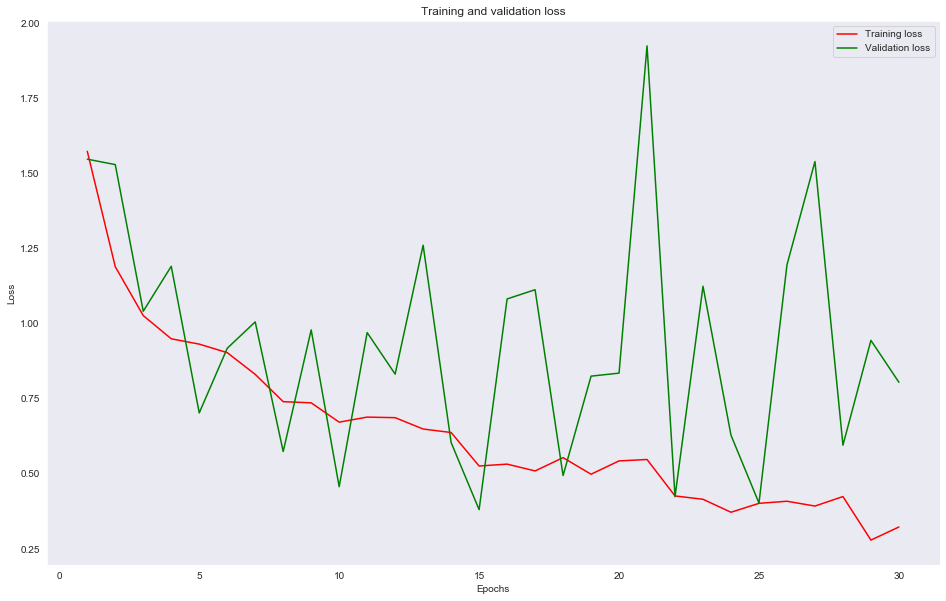

In [18]:
plotloss(history_dict)

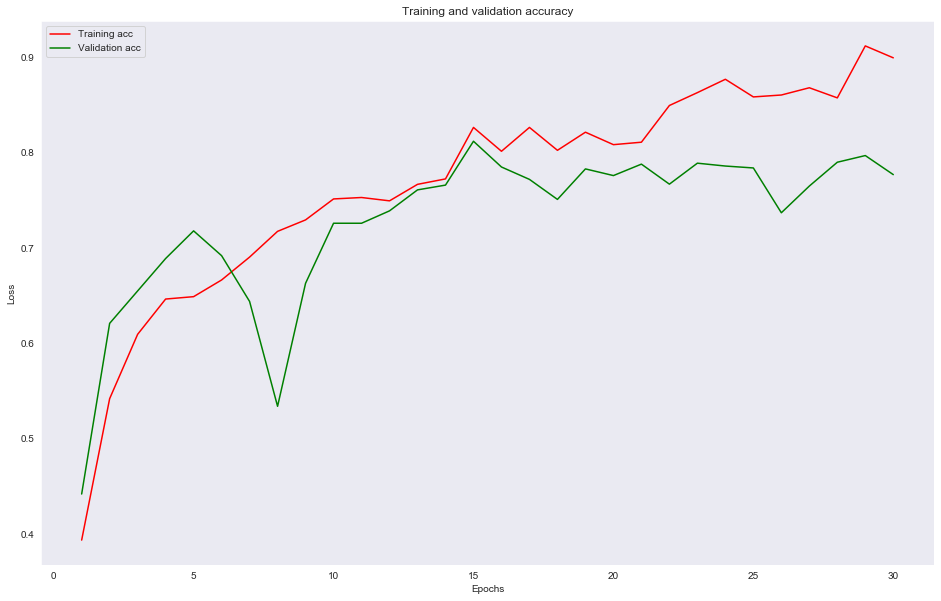

In [19]:
plotacc(history)

In [20]:
# test_loss, test_acc = model.evaluate(test_images, test_labels)
# test_acc

In [21]:
model.save('intel_classes_1.h5')

## Fine-Tuning or Transfer Learning

In [22]:
from keras.applications import VGG16
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3))

In [23]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [28]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 1542      
Total params: 16,813,638
Trainable params: 9,178,374
Non-trainable params: 7,635,264
_________________________________________________________________


In [29]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [30]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
                loss='categorical_crossentropy',
                metrics=['acc'])

In [31]:
# model.fit(train_images, train_labels, epochs=5, batch_size=64)
history = model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=12,
        validation_data=validation_generator,
        validation_steps=50)

Epoch 1/12
100/100 [==============================] - 9s 94ms/step - loss: 0.6710 - acc: 0.7655 - val_loss: 0.2980 - val_acc: 0.8710
Epoch 2/12
100/100 [==============================] - 9s 91ms/step - loss: 0.3790 - acc: 0.8610 - val_loss: 0.3756 - val_acc: 0.8640
Epoch 3/12
100/100 [==============================] - 9s 91ms/step - loss: 0.3245 - acc: 0.8935 - val_loss: 0.1220 - val_acc: 0.8730
Epoch 4/12
100/100 [==============================] - 9s 91ms/step - loss: 0.2870 - acc: 0.8997 - val_loss: 0.3432 - val_acc: 0.8840
Epoch 5/12
100/100 [==============================] - 9s 92ms/step - loss: 0.3108 - acc: 0.8840 - val_loss: 0.2672 - val_acc: 0.8990
Epoch 6/12
100/100 [==============================] - 9s 92ms/step - loss: 0.2774 - acc: 0.9070 - val_loss: 0.2227 - val_acc: 0.9000
Epoch 7/12
100/100 [==============================] - 9s 92ms/step - loss: 0.2957 - acc: 0.8970 - val_loss: 0.2248 - val_acc: 0.8940
Epoch 8/12
100/100 [==============================] - 9s 92ms/step - 

### ran for 30 epochs re-run for 12 because it looked like the best

In [32]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

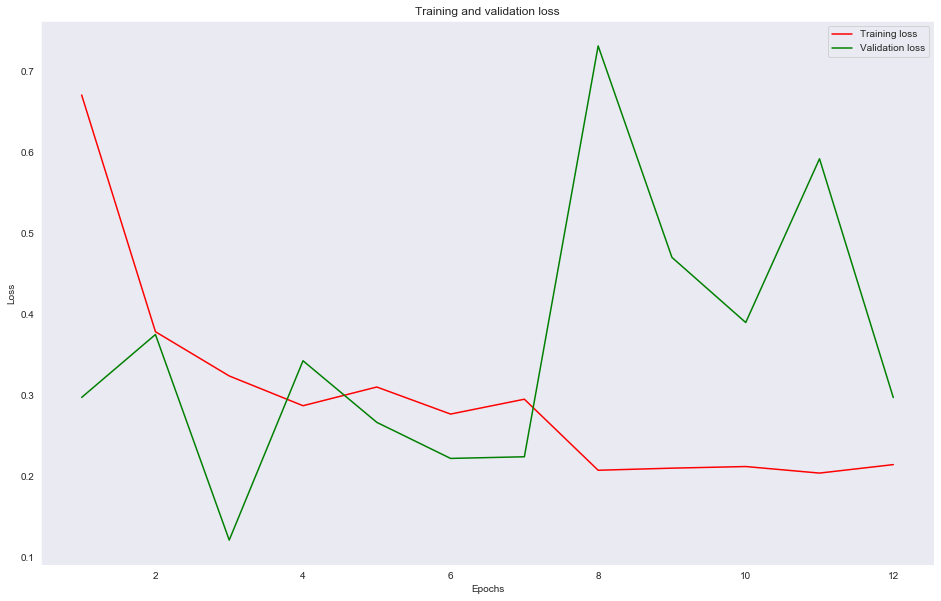

In [33]:
plotloss(history_dict)

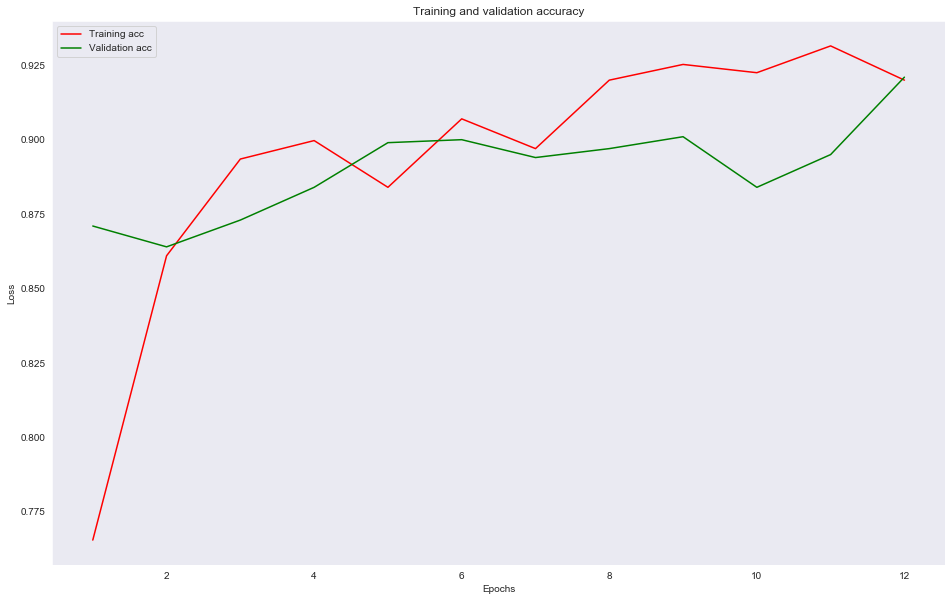

In [34]:
plotacc(history)

In [35]:
model.save('intel_classes_2.h5')

### I created a small test set out of the images in the folder seg_pred because they are not labeled. I did my best to label them myself. I went for images that made the most sense and some that would be tricky but were still obvious for a human being. The folder is called test and is included in this folder.

In [36]:
model.evaluate_generator(validation_generator)

[0.08309371769428253, 0.9073333144187927]

### Looking at activations for fun

In [37]:
from keras.models import load_model
model = load_model('intel_classes_1.h5')
model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 73984)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

In [38]:
img_path = os.getcwd() + '\\intel-image-classification\\test\\forest\\152.jpg'
from keras.preprocessing import image
import numpy as np
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

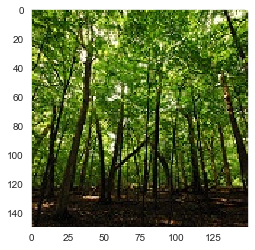

In [39]:
plt.imshow(img_tensor[0])
plt.show()

In [40]:
layer_outputs = [layer.output for i, layer in enumerate(model.layers[:8])]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [41]:
activations = activation_model.predict(img_tensor)

In [42]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


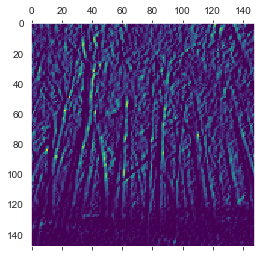

In [43]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

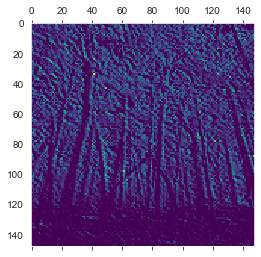

In [44]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

MemoryError: Unable to allocate 2.88 PiB for an array with shape (342102016, 1183744) and data type float64

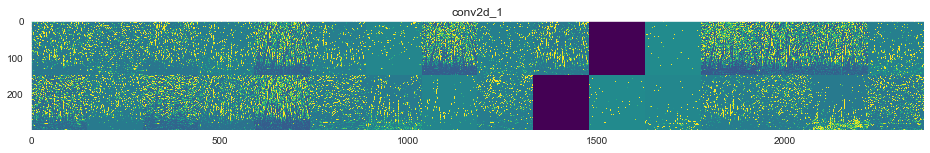

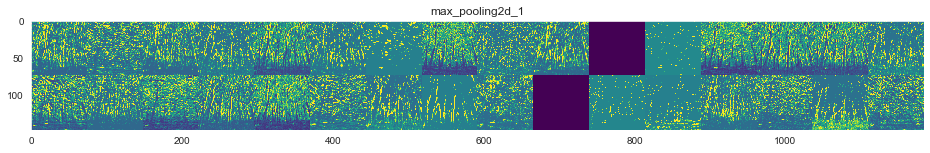

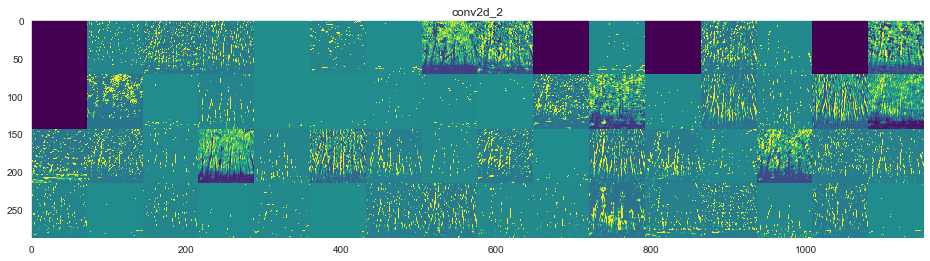

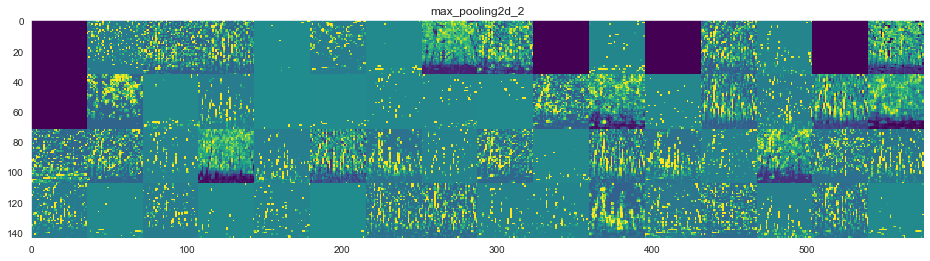

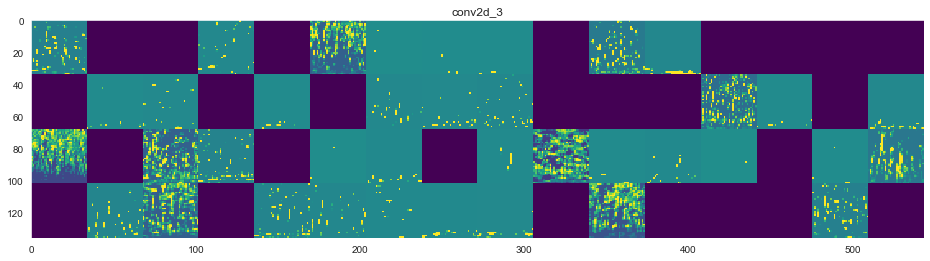

In [46]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [47]:
# Visualizing convnet filters
# Defining the loss tensor for filter visualization
from keras.applications import VGG16
from keras import backend as K
model = VGG16(weights='imagenet',
include_top=False)
layer_name = 'block3_conv1'
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [48]:
#Obtaining the gradient of the loss with regard to the input
grads = K.gradients(loss, model.input)[0] #The call to gradients returns a list of tensors (of size 1 in this case). 
                                          #Hence, you keep only the first element which is a tensor.
#Gradient-normalization trick
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) #Add 1e–5 before dividing to avoid accidentally dividing by 0.

In [49]:
#Fetching Numpy output values given Numpy input values
iterate = K.function([model.input], [loss, grads])
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [50]:
#Loss maximization via stochastic gradient descent
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [51]:
#Utility function to convert a tensor into a valid image
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [52]:
def generate_pattern(layer_name, filter_index, size=80):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

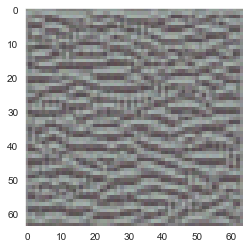

In [53]:
plt.imshow(generate_pattern('block1_conv1', 10,size=64))

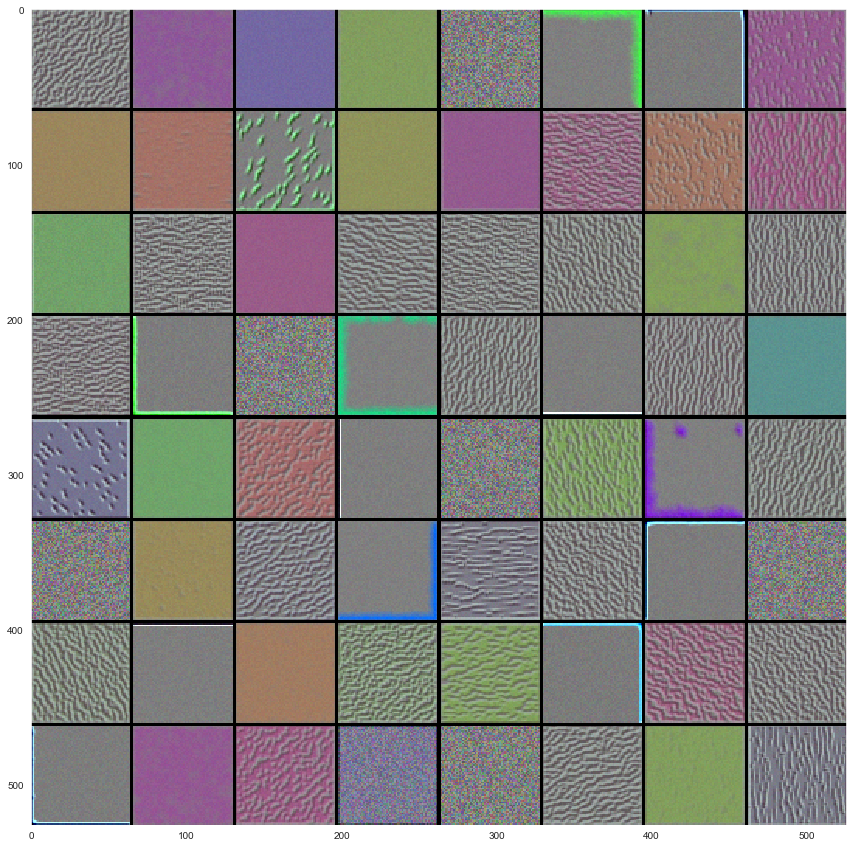

In [54]:
layer_name = 'block1_conv1'
size = 64
margin = 2
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))
for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        #print(horizontal_start,horizontal_end,vertical_start,vertical_end)
        results[horizontal_start:horizontal_end, vertical_start:vertical_end, :] = filter_img
plt.figure(figsize=(15, 15))
plt.imshow(results.astype(np.uint8))

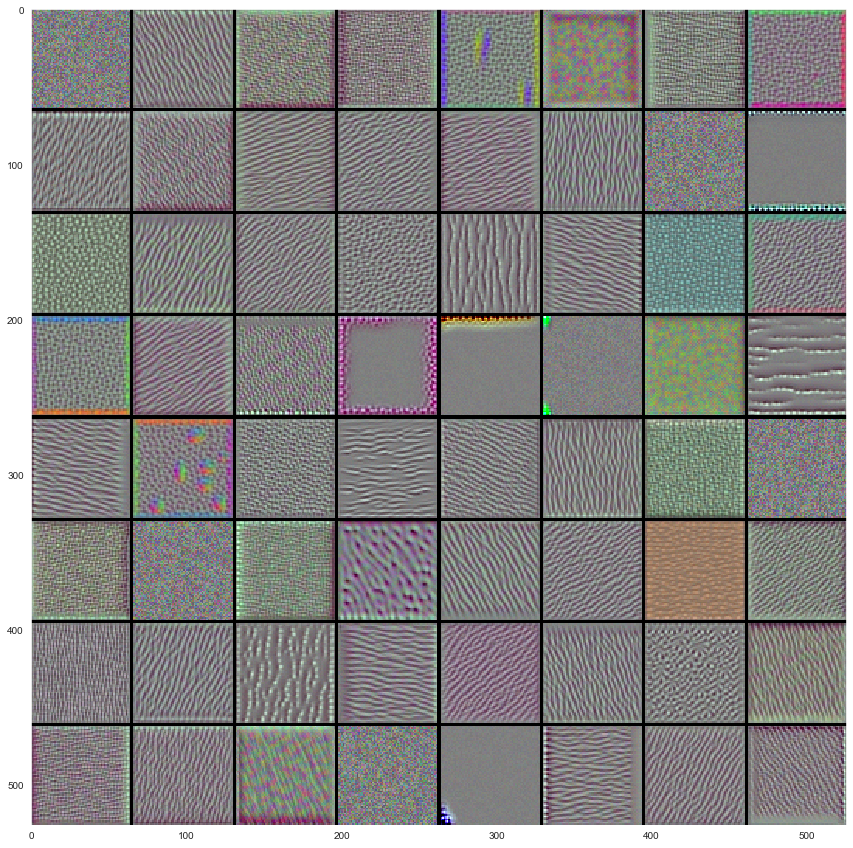

In [55]:
layer_name = 'block2_conv1'
size = 64
margin = 2
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))
for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        #print(horizontal_start,horizontal_end,vertical_start,vertical_end)
        results[horizontal_start:horizontal_end, vertical_start:vertical_end, :] = filter_img
plt.figure(figsize=(15, 15))
plt.imshow(results.astype(np.uint8))

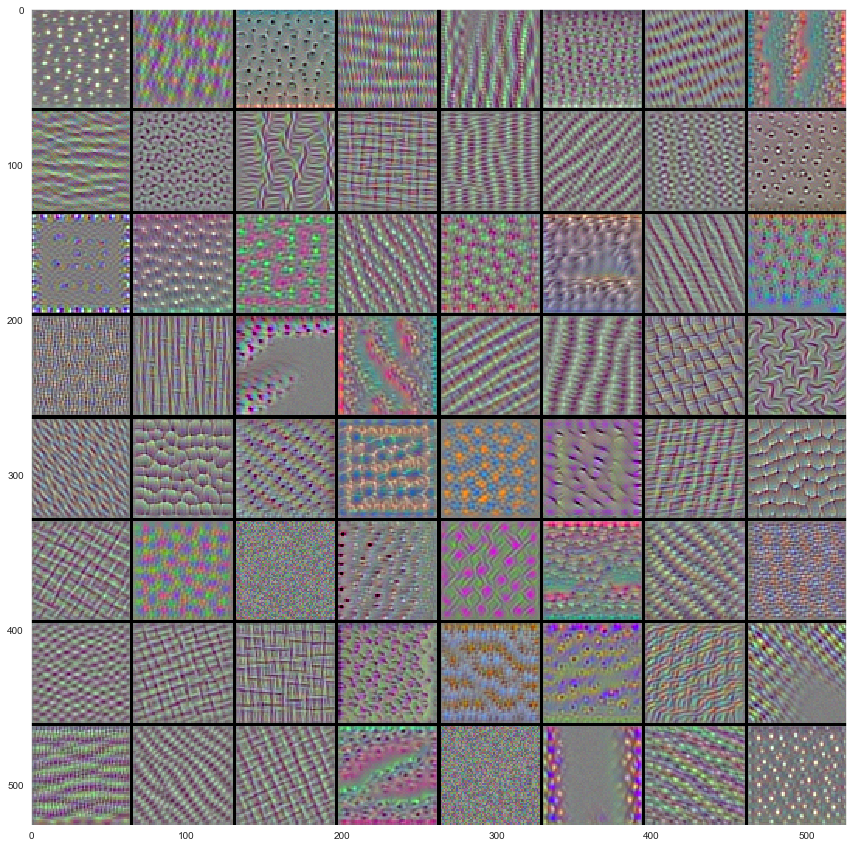

In [56]:
layer_name = 'block3_conv1'
size = 64
margin = 2
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))
for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        #print(horizontal_start,horizontal_end,vertical_start,vertical_end)
        results[horizontal_start:horizontal_end, vertical_start:vertical_end, :] = filter_img
plt.figure(figsize=(15, 15))
plt.imshow(results.astype(np.uint8))

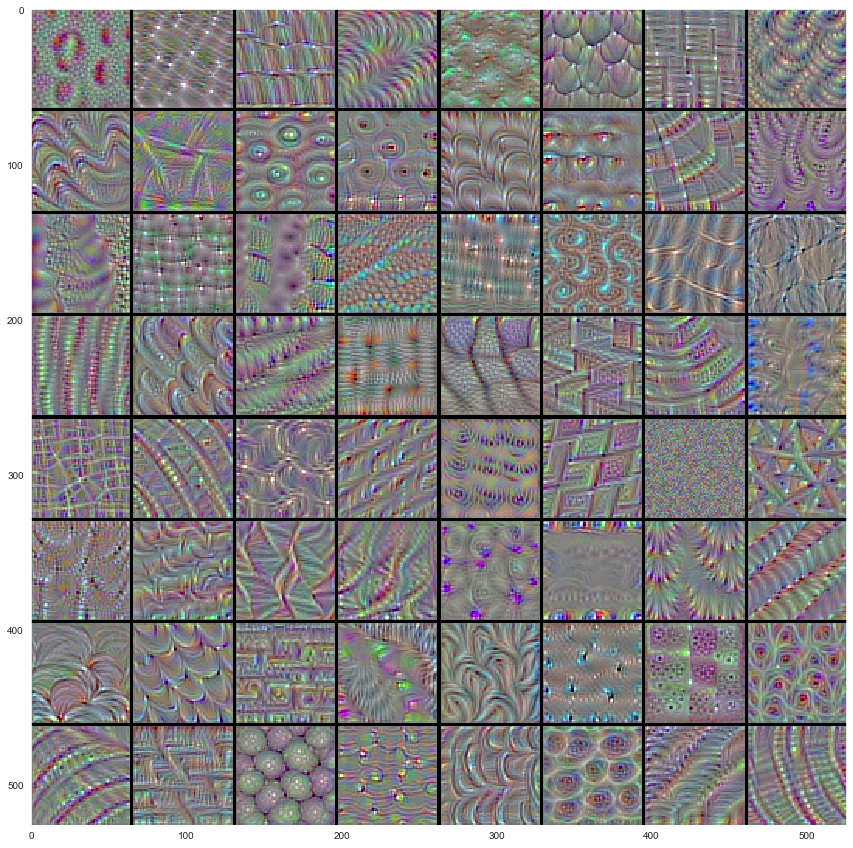

In [57]:
layer_name = 'block4_conv1'
size = 64
margin = 2
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))
for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        #print(horizontal_start,horizontal_end,vertical_start,vertical_end)
        results[horizontal_start:horizontal_end, vertical_start:vertical_end, :] = filter_img
plt.figure(figsize=(15, 15))
plt.imshow(results.astype(np.uint8))